# ImageNet Sample Prelims

Preparing to train a new model on ImageNet by going through a sample set of it first.

##  Imports, Paths

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.models import darknet

In [3]:
from pathlib import Path
import os
import pandas as pd

In [4]:
PATH = Path('data/imagenet')
PATH_TRAIN = PATH/'train'

In [5]:
PATH, PATH_TRAIN

(PosixPath('data/imagenet'), PosixPath('data/imagenet/train'))

## I. Taking a look at Data

In [6]:
folder = os.listdir(PATH_TRAIN)[0]
os.listdir(PATH_TRAIN/folder)

['n02894605_44136.JPEG',
 'n02894605_70618.JPEG',
 'n02894605_57969.JPEG',
 'n02894605_57217.JPEG',
 'n02894605_26115.JPEG',
 'n02894605_79044.JPEG',
 'n02894605_36918.JPEG',
 'n02894605_74409.JPEG',
 'n02894605_57337.JPEG',
 'n02894605_26864.JPEG',
 'n02894605_15211.JPEG',
 'n02894605_61478.JPEG',
 'n02894605_103868.JPEG',
 'n02894605_86482.JPEG',
 'n02894605_25816.JPEG',
 'n02894605_121711.JPEG',
 'n02894605_29318.JPEG',
 'n02894605_24721.JPEG',
 'n02894605_51257.JPEG',
 'n02894605_29824.JPEG',
 'n02894605_13652.JPEG',
 'n02894605_34440.JPEG',
 'n02894605_57537.JPEG',
 'n02894605_2436.JPEG',
 'n02894605_64529.JPEG',
 'n02894605_36723.JPEG',
 'n02894605_24755.JPEG']

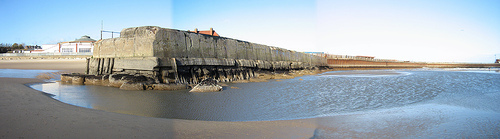

In [16]:
fimg = PATH_TRAIN / folder / os.listdir(PATH_TRAIN/folder)[0]
Image.open(fimg)

In [6]:
def view_img(folder_path, idx=-1):
    files = os.listdir(folder_path)
    if idx < 0: idx = np.random.randint(len(files))
        
    fimg = str(folder_path / files[idx])
    img = cv2.imread(str(fimg))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

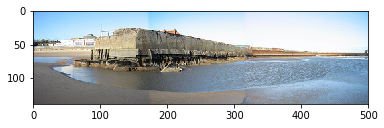

In [49]:
view_img(PATH_TRAIN/folder, idx=0)

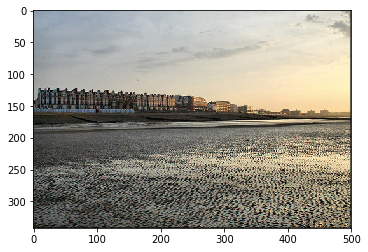

In [50]:
view_img(PATH_TRAIN/folder)

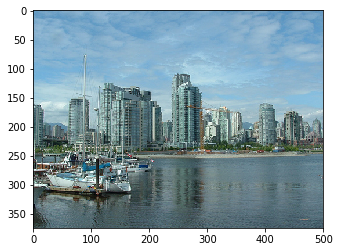

In [51]:
view_img(PATH_TRAIN/folder)

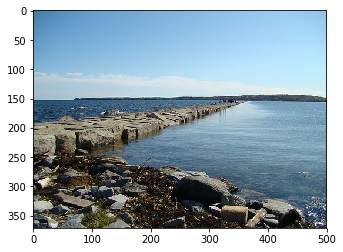

In [52]:
view_img(PATH_TRAIN/folder)

In [12]:
# os.listdir(PATH_TRAIN)

# folders = os.listdir(PATH_TRAIN)
# for folder in folders:
#     print(f'{len(os.listdir(PATH_TRAIN/folder))}')

## II. ImageNet labels lookup dictionary

Got these from: https://gist.github.com/aaronpolhamus/964a4411c0906315deb9f4a3723aac57

In [7]:
imagenet_labels = pd.read_csv(PATH/'imagenet_labels.txt', delim_whitespace=True, header=None)

In [8]:
imagenet_labels.head()

,0,1,2
0,n02119789,1,kit_fox
1,n02100735,2,English_setter
2,n02110185,3,Siberian_husky
3,n02096294,4,Australian_terrier
4,n02102040,5,English_springer


I'm not sure whether I should keep the class number or not - since I think that's an internal detail that's handled automatically - so I'll just make a CSV matching folder codes to class names.

In [26]:
# imagenet_labels = imagenet_labels.drop(columns=[1])

On second thought, I can just use the `.from_paths` fastai method, and have a dictionary to lookup classes.

In [35]:
imagenet_labels.as_matrix()

array([['n02119789', 1, 'kit_fox'],
       ['n02100735', 2, 'English_setter'],
       ['n02110185', 3, 'Siberian_husky'],
       ...,
       ['n04325704', 998, 'stole'],
       ['n07831146', 999, 'carbonara'],
       ['n03255030', 1000, 'dumbbell']], dtype=object)

In [41]:
# {c0 : c2 for c0,_,c2 in imagenet_labels.as_matrix()}

In [9]:
imagenet_labels_lookup = {c0 : c2 for c0,_,c2 in imagenet_labels.as_matrix()}

## III. Validation Set

In [9]:
def reset_valset(path):
    path_val = path/'valid'
    path_trn = path/'train'
    
    if not os.path.exists(path_val):
        print('No validation directory to reset.')
        return
    
    for folder in path_val.iterdir():
        for f in folder.iterdir():
            os.rename(f, path_trn / str(f).split('valid/')[-1])

def create_valset(path, p=0.15, seed=0):
    np.random.seed(seed=seed)
    
    path_val = path/'valid'
    path_trn = path/'train'
    reset_valset(path)
    
    # move random p-percent selection from train/ to valid/
    for folder in path_trn.iterdir():
        os.makedirs(path_val/str(folder).split('train/')[-1], exist_ok=True)
        flist = list(folder.iterdir())
        n_move = int(np.round(len(flist) * p))
        fmoves = np.random.choice(flist, n_move, replace=False)
        
        for f in fmoves:
            os.rename(f, path_val / str(f).split('train/')[-1])

def count_files(path):
    count = 0
    for folder in path.iterdir():
        count += len(list(folder.glob('*')))
    return count

In [161]:
count_files(PATH_TRAIN)

19439

In [164]:
reset_valset(PATH)

No validation directory to reset.


In [208]:
create_valset(PATH)

In [209]:
count_files(PATH_TRAIN)

16545

In [211]:
19439 * (1 - .15)

16523.149999999998

In [11]:
count_files(PATH/'valid')

2894

In [20]:
reset_valset(PATH)
count_files(PATH_TRAIN), count_files(PATH/'valid')

(19439, 0)

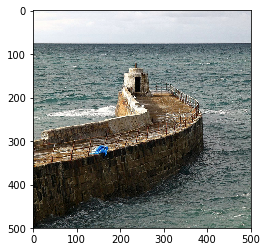

In [217]:
folder = next(iter(PATH_TRAIN.iterdir()))
view_img(folder)

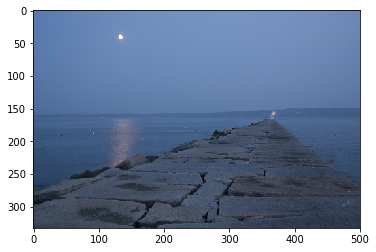

In [218]:
folder = next(iter((PATH/'valid').iterdir()))
view_img(folder)

## IV. Training Darknet on ImageNet sampleset

In [13]:
sz = 256
bs = 32

darknet53 = darknet.darknet_53()

# tfms = tfms_from_stats(imagenet_stats, sz, aug_tfms=transforms_side_on, max_zoom=1.05, pad=sz//8)

# tfms = tfms_from_model(darknet53, sz) # loads imagenet_stats
tfms = tfms_from_model(resnet34, sz)

model_data = ImageClassifierData.from_paths(PATH, bs=bs, tfms=tfms, num_workers=4)

In [14]:
learner = ConvLearner.from_model_data(darknet53, data)
# learner = ConvLearner.from_model_data(darknet53, model_data)
# learner.crit = F.nll_loss

In [15]:
learner.crit

<function torch.nn.functional.nll_loss(input, target, weight=None, size_average=True, ignore_index=-100, reduce=True)>

In [16]:
# learner.summary()

In [ ]:
learner.lr_find()
learner.sched.plot(10,5)

  0%|          | 4/828 [00:13<44:40,  3.25s/it, loss=-0.00232] 

### Copying Sgugger ModelData way

---

In [14]:
sz = 256
bs = 32

tfms = tfms_from_stats(imagenet_stats, sz, aug_tfms=transforms_side_on, max_zoom=1.05, pad=sz//8)
model_data = ImageClassifierData.from_paths(PATH, bs=bs, tfms=tfms, num_workers=4)

model_data = get_data(sz,bs)

darknet53 = darknet.darknet_53()

In [15]:
learner = ConvLearner.from_model_data(darknet53, model_data)
learner.crit = F.nll_loss

In [ ]:
learner.lr_find()

  2%|▏         | 8/414 [00:40<33:53,  5.01s/it, loss=0.0605]  

---

## V. Sanity Check: Replicating Darknet53

Making sure I can get similar performance to [Sylvain Gugger's implementation of Darknet53](https://github.com/sgugger/Deep-Learning/blob/master/Resnet%2050%20and%20Darknet%2053.ipynb).

In [6]:
# list((PATH/'train').iterdir())

In [22]:
L = list((PATH/'train').iterdir())
L1 = L[1].glob('*')
# list(L1)

In [23]:
filenames, classes = [], []
TRN_PATH = (PATH/'train')
for directory in TRN_PATH.iterdir():
    for fn in directory.glob('*'):
        filenames.append(str(fn)[len(str(TRN_PATH))+1:])
        classes.append(str(directory)[len(str(TRN_PATH))+1:])
class_names = list(set(classes))
class2idx = {c:i for i,c in enumerate(class_names)}
labels = [class2idx[c] for c in classes]

In [24]:
df = pd.DataFrame({'filenames':filenames, 'cats':labels}, columns=['filenames', 'cats'])
df.head()

,filenames,cats
0,n02894605/n02894605_44136.JPEG,233
1,n02894605/n02894605_70618.JPEG,233
2,n02894605/n02894605_57969.JPEG,233
3,n02894605/n02894605_57217.JPEG,233
4,n02894605/n02894605_26115.JPEG,233


In [25]:
df.to_csv(PATH/'train.csv', index=False)

In [11]:
# stats = (np.array([0.4855, 0.456, 0.406]), np.array([0.229, 0.224, 0.225]))

In [12]:
def get_data(sz,bs):
    tfms = tfms_from_model(resnet50,sz)
    return ImageClassifierData.from_csv(PATH,'train',PATH/'train.csv',bs=bs,tfms=tfms)

In [13]:
size = 256
batch_size = 16
data = get_data(size, batch_size)

### Darknet

In [14]:
class ConvBN(nn.Module):
    # convolutional layer then BatchNorm
    def __init__(self, ch_in, ch_out, kernel_size=3, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(ch_in, ch_out, kernel_size=kernel_size, stride=stride,
                              padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(ch_out, momentum=0.01)
    
    def forward(self, x):
        return F.leaky_relu(self.bn(self.conv(x)), negative_slope=0.1)
    
class DarknetBlock(nn.Module):
    # the basic blocks
    def __init__(self, ch_in):
        super().__init__()
        ch_hid = ch_in//2
        self.conv1 = ConvBN(ch_in, ch_hid, kernel_size=1, stride=1, padding=0)
        self.conv2 = ConvBN(ch_hid, ch_in, kernel_size=3, stride=1, padding=1)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        return out + x
    
class Darknet(nn.Module):
    # Replicates table 1 from the YOLOv3 paper
    def __init__(self, num_blocks, num_classes=1000):
        super().__init__()
        self.conv = ConvBN(3, 32, kernel_size=3, stride=1, padding=1)
        self.layer1 = self.make_group_layer(32, num_blocks[0])
        self.layer2 = self.make_group_layer(64, num_blocks[1], stride=2)
        self.layer3 = self.make_group_layer(128,num_blocks[2], stride=2)
        self.layer4 = self.make_group_layer(256,num_blocks[3], stride=2)
        self.layer5 = self.make_group_layer(512,num_blocks[4], stride=2)
        self.linear = nn.Linear(1024, num_classes)
        
    def make_group_layer(self, ch_in, num_blocks, stride=1):
        layers = [ConvBN(ch_in, ch_in*2, stride=stride)]
        for i in range(num_blocks):
            layers.append(DarknetBlock(ch_in*2))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        return F.log_softmax(self.linear(out))

In [15]:
darknet53 = Darknet([1,2,8,8,4])

In [14]:
darknet53 = darknet.darknet_53()

In [15]:
learn = ConvLearner.from_model_data(darknet53, data)
learn.crit = F.nll_loss

In [16]:
# learn.summary()

In [17]:
learn.lr_find()

  3%|▎         | 24/828 [01:09<39:03,  2.91s/it, loss=0.033]   

In [18]:
learn.lr_find()

 25%|██▌       | 207/828 [10:22<31:06,  3.00s/it, loss=7]   

KeyboardInterrupt: 

## Va .DataLoader Preliminary Tests

In [6]:
## these parameters are universal
sz = 256
bs = 32

darknet53 = darknet.darknet_53()

In [7]:
## the .from_paths way (mine) with stock transforms
tfms = tfms_from_stats(imagenet_stats, sz)
model_data = ImageClassifierData.from_paths(PATH, bs=bs, tfms=tfms, val_name='train')

In [7]:
## the .from_csv way with stock transforms
tfms = tfms_from_model(resnet50, sz)
model_data = ImageClassifierData.from_csv(PATH, 'train', PATH/'train.csv', 
                                          bs=bs, tfms=tfms)

`.from_paths`

 12%|█▏        | 74/608 [05:26<39:13,  4.41s/it, loss=0.0239]  

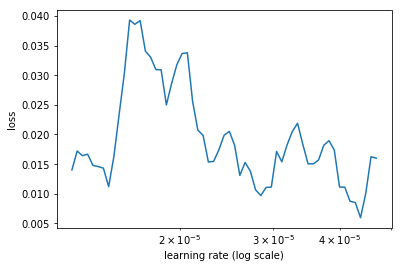

In [8]:
learner = ConvLearner.from_model_data(darknet53, model_data)
learner.lr_find()
learner.sched.plot()

`.from_csv`

In [8]:
learner = ConvLearner.from_model_data(darknet53, model_data)
learner.lr_find()
learner.sched.plot()

  4%|▍         | 16/414 [01:17<32:12,  4.86s/it, loss=-0.000439]

KeyboardInterrupt: 

`.from_paths` starts at -0.0007 or so, reaches above 0 within 3'ish iterations, and runs at around 5s/it.

`.from_csv` starts at -0.00366, dips to -0.0213 at iter 4, and prompty gets back up above 0, dipping below again at iter 7 & going back above at 8. Runs at around 5s/it.

They both seem just about the same, when transforms are set to stock.

However, I need to know why number of iterations was out of 608 for `.from_paths` and 414 for `.from_csv`. First I need to ensure the dataset size is equal for both DataLoader methods.

--> right, I answered that question - was silly. The procedure above built the CSV from files in the training directory -- which was *after* I created the validation set. So it had only read the training set files, and *not* the full dataset. Meaning also: if I hadn't reset the validation set before running the test above, both methods (.from_csv and .from_paths) would have had the same number of total iterations (414 in that case).

In [11]:
## dataset size for .from_paths:
count_files(PATH/'train')

19439

In [26]:
## dataset size for .from_csv:
df = pd.read_csv(PATH/'train.csv')
df.items

<bound method DataFrame.iteritems of                              filenames  cats
0       n02894605/n02894605_44136.JPEG   233
1       n02894605/n02894605_70618.JPEG   233
2       n02894605/n02894605_57969.JPEG   233
3       n02894605/n02894605_57217.JPEG   233
4       n02894605/n02894605_26115.JPEG   233
5       n02894605/n02894605_79044.JPEG   233
6       n02894605/n02894605_36918.JPEG   233
7       n02894605/n02894605_74409.JPEG   233
8       n02894605/n02894605_57337.JPEG   233
9       n02894605/n02894605_26864.JPEG   233
10      n02894605/n02894605_15211.JPEG   233
11      n02894605/n02894605_61478.JPEG   233
12     n02894605/n02894605_103868.JPEG   233
13      n02894605/n02894605_86482.JPEG   233
14      n02894605/n02894605_25816.JPEG   233
15     n02894605/n02894605_121711.JPEG   233
16      n02894605/n02894605_29318.JPEG   233
17      n02894605/n02894605_24721.JPEG   233
18      n02894605/n02894605_51257.JPEG   233
19      n02894605/n02894605_29824.JPEG   233
20      n02894605/

So now that I'm getting the same performance - as a sanity check that I'm not doing something very wrong - the only question that remains now is: what is the effect of different transforms on the Learner's ability to train. Am I breaking things by using wrong / bad transforms? Let's find out.

## Vb. DataLoader Tests:

### Checking transforms_from_stats vs transforms_from_model

tfms_from_stats(imagenet_stats) == tfms_from_model(darknet53) == tfms_from_model(resnet50) ?

In [6]:
sz = 256
bs = 32
darknet53 = darknet.darknet_53()

In [7]:
# tfms = tfms_from_stats(imagenet_stats, sz)
# tfms = tfms_from_model(darknet53, sz)
tfms = tfms_from_model(resnet50, sz)

In [8]:
model_data = ImageClassifierData.from_paths(PATH, bs=bs, tfms=tfms, val_name='train')

In [9]:
learner = ConvLearner.from_model_data(darknet53, model_data)

`tfms = tfms_from_stats(imagenet_stats, sz)`:

Worked after about 2 failures.

 13%|█▎        | 77/608 [05:39<39:00,  4.41s/it, loss=0.0117]  

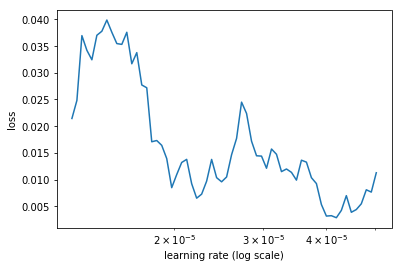

In [10]:
learner.lr_find()
learner.sched.plot()

`tfms = tfms_from_model(darknet53, sz)`:

Worked after about 2 failures.

  8%|▊         | 49/608 [03:37<41:24,  4.44s/it, loss=0.0326]  

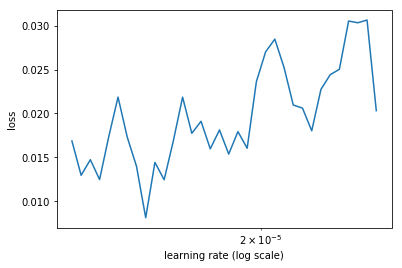

In [10]:
learner.lr_find()
learner.sched.plot()

`tfms = tfms_from_model(resnet50, sz)`:

After 4 failures: the 1st plot. Subsequent try resulted in a similar 'low-res' plot. 1 more failture, then the 2nd plot was created.

  3%|▎         | 20/608 [01:38<48:22,  4.94s/it, loss=0.0251]  

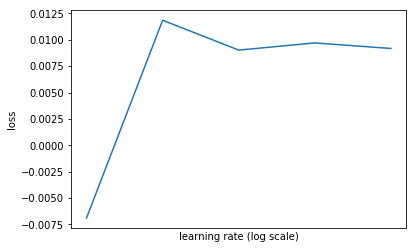

In [10]:
learner.lr_find()
learner.sched.plot()

 23%|██▎       | 137/608 [10:36<36:28,  4.65s/it, loss=-0.00101] 

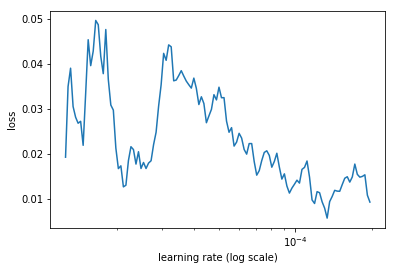

In [10]:
learner.lr_find()
learner.sched.plot()